In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

zsh:1: command not found: wget
unzip:  cannot find or open jena_climate_2009_2016.csv.zip, jena_climate_2009_2016.csv.zip.zip or jena_climate_2009_2016.csv.zip.ZIP.


In [2]:
filename = 'jena_climate_2009_2016.csv'

with open(filename) as f:
    data = f.read()

    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    print(header)
    print(len(lines))

for line in lines[:10]:
    print(line)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.

In [3]:
import numpy as np
n_lines = len(lines)
n_headers = len(header)
temperature = np.zeros((n_lines,))
raw_data = np.zeros((n_lines, n_headers - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # 1: to skip the date time column
    temperature[i] = values[1]
    raw_data[i,] = values

print(temperature[:3])
print(raw_data[:3, :3])

[-8.02 -8.41 -8.51]
[[996.52  -8.02 265.4 ]
 [996.57  -8.41 265.01]
 [996.53  -8.51 264.91]]


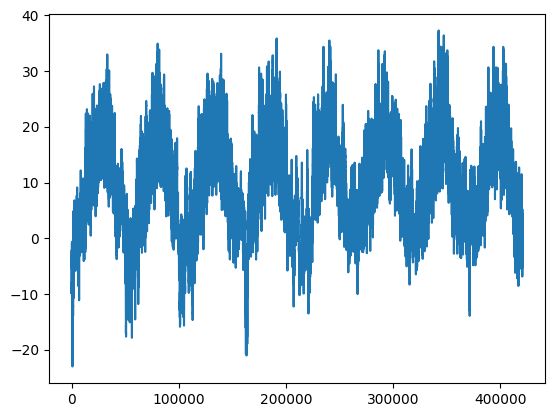

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(n_lines), temperature)

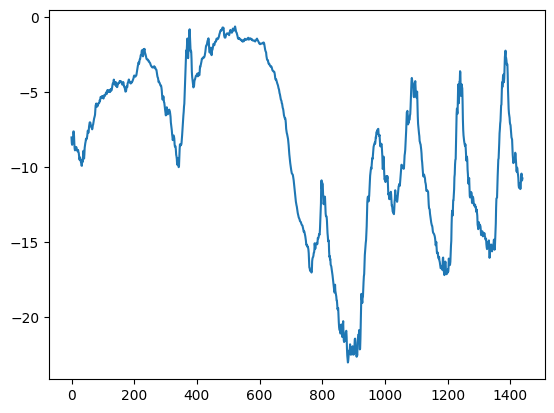

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
n_train = int(0.5 * n_lines)
n_val = int(0.25 * n_lines)
n_test = n_lines - n_train - n_val
print(n_train, n_val, n_test)

210225 105112 105114


In [7]:
print(raw_data[:3,:3])
mean = raw_data[:n_train].mean(axis=0)
std = raw_data[:n_train].std(axis=0)
z = (raw_data - mean) / std
print(z[:n_train].mean(axis=0), z[:n_train].std(axis=0))

[[996.52  -8.02 265.4 ]
 [996.57  -8.41 265.01]
 [996.53  -8.51 264.91]]
[ 2.41448143e-12 -3.04937772e-15  6.68831382e-13 -1.47390162e-14
  3.51971409e-15  5.17726056e-15 -1.97806893e-14 -1.56825520e-14
  3.62590596e-14  3.44193167e-15 -2.11724873e-13  1.60843651e-14
 -5.38064190e-14 -2.19450964e-15] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=n_train + n_val
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    z[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train + n_val
)

In [9]:
for samples, targets in train_dataset:
    print('batch samples shape: ', samples.shape)
    print('batch targets shape: ', targets.shape)
    break

batch samples shape:  (256, 120, 14)
batch targets shape:  (256,)


In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(evaluate_naive_method(train_dataset), evaluate_naive_method(val_dataset), evaluate_naive_method(test_dataset))

2.6916438277703802 2.441732600241383 2.622035888818064


In [11]:
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, callbacks

inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation=activations.relu)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
callback_list = [
    callbacks.ModelCheckpoint('jena_dense', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)

model = keras.models.load_model('jena_dense')
print(model.evaluate(test_dataset))


Epoch 1/10
806/819 [============================>.] - ETA: 0s - loss: 12.8100 - mean_absolute_error: 2.7741INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 13s 15ms/step - loss: 12.7614 - mean_absolute_error: 2.7693 - val_loss: 12.2004 - val_mean_absolute_error: 2.7273
Epoch 2/10
810/819 [============================>.] - ETA: 0s - loss: 9.3449 - mean_absolute_error: 2.3991INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 13s 15ms/step - loss: 9.3527 - mean_absolute_error: 2.3999 - val_loss: 11.1528 - val_mean_absolute_error: 2.6235
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 8.5653 - mean_absolute_error: 2.2976 - val_loss: 11.4682 - val_mean_absolute_error: 2.6556
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 8.1494 - mean_absolute_error: 2.2437 - val_loss: 11.5331 - val_mean_absolute_error: 2.6644
Epoch 5/10
809/819 [============================>.] - ETA: 0s - loss: 7.8369 - mean_absolute_error: 2.2040INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 13s 15ms/step - loss: 7.8377 - mean_absolute_error: 2.2041 - val_loss: 10.8715 - val_mean_absolute_error: 2.5963
Epoch 6/10
807/819 [============================>.] - ETA: 0s - loss: 7.5733 - mean_absolute_error: 2.1648INFO:tensorflow:Assets written to: jena_dense/assets


INFO:tensorflow:Assets written to: jena_dense/assets


819/819 [==============================] - 12s 14ms/step - loss: 7.5719 - mean_absolute_error: 2.1646 - val_loss: 10.7069 - val_mean_absolute_error: 2.5728
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 7.3669 - mean_absolute_error: 2.1367 - val_loss: 12.4561 - val_mean_absolute_error: 2.8025
Epoch 8/10
819/819 [==============================] - 12s 15ms/step - loss: 7.1870 - mean_absolute_error: 2.1094 - val_loss: 12.3928 - val_mean_absolute_error: 2.7927
Epoch 9/10
819/819 [==============================] - 12s 15ms/step - loss: 7.0345 - mean_absolute_error: 2.0888 - val_loss: 10.7276 - val_mean_absolute_error: 2.5830
Epoch 10/10
405/405 [==============================] - 4s 10ms/step - loss: 11.7394 - mean_absolute_error: 2.6777
[11.73936939239502, 2.6776950359344482]


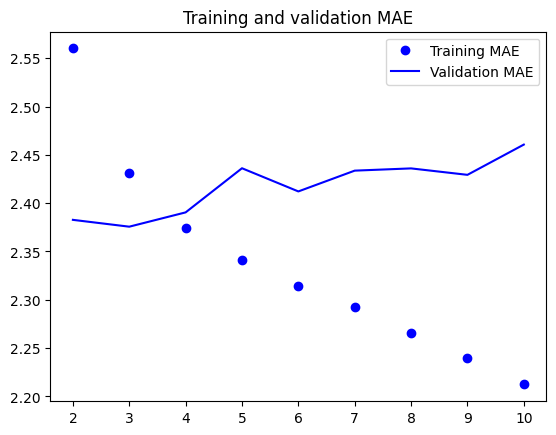

In [36]:
import matplotlib.pyplot as plt

loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs[1:], loss[1:], 'bo', label='Training MAE')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()


In [13]:
inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.Conv1D(filters=8, kernel_size=24, activation=activations.relu)(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=12, activation=activations.relu)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=8, kernel_size=6, activation=activations.relu)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callback_list = [
    callbacks.ModelCheckpoint('jena_conv', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)

model = keras.models.load_model('jena_conv')
print(model.evaluate(test_dataset))


Epoch 1/10
816/819 [============================>.] - ETA: 0s - loss: 23.7657 - mean_absolute_error: 3.7550INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


819/819 [==============================] - 16s 19ms/step - loss: 23.7399 - mean_absolute_error: 3.7529 - val_loss: 18.0017 - val_mean_absolute_error: 3.3359
Epoch 2/10
817/819 [============================>.] - ETA: 0s - loss: 15.3067 - mean_absolute_error: 3.1118INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


819/819 [==============================] - 16s 19ms/step - loss: 15.3054 - mean_absolute_error: 3.1116 - val_loss: 15.2469 - val_mean_absolute_error: 3.0707
Epoch 3/10
814/819 [============================>.] - ETA: 0s - loss: 13.9351 - mean_absolute_error: 2.9656INFO:tensorflow:Assets written to: jena_conv/assets


INFO:tensorflow:Assets written to: jena_conv/assets


819/819 [==============================] - 16s 19ms/step - loss: 13.9411 - mean_absolute_error: 2.9662 - val_loss: 14.2419 - val_mean_absolute_error: 2.9690
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 13.0068 - mean_absolute_error: 2.8592 - val_loss: 14.6298 - val_mean_absolute_error: 3.0106
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 12.3257 - mean_absolute_error: 2.7802 - val_loss: 14.8972 - val_mean_absolute_error: 3.0524
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 11.7724 - mean_absolute_error: 2.7160 - val_loss: 17.0979 - val_mean_absolute_error: 3.2079
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 11.2933 - mean_absolute_error: 2.6600 - val_loss: 15.2568 - val_mean_absolute_error: 3.0563
Epoch 8/10
819/819 [==============================] - 16s 19ms/step - loss: 10.9404 - mean_absolute_error: 2.6161 - val_loss: 14.3798 - val_mean_absolute_error: 3.0021
Epo

In [14]:
inputs = layers.Input(shape=(sequence_length, z.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callback_list = [
    callbacks.ModelCheckpoint('jena_lstm', save_best_only=True)
]
model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callback_list)
model = keras.models.load_model('jena_lstm')
print(model.evaluate(test_dataset))

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 39.7630 - mean_absolute_error: 4.5924INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 26s 31ms/step - loss: 39.7630 - mean_absolute_error: 4.5924 - val_loss: 12.4748 - val_mean_absolute_error: 2.6892
Epoch 2/10
817/819 [============================>.] - ETA: 0s - loss: 10.8744 - mean_absolute_error: 2.5605INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 25s 30ms/step - loss: 10.8710 - mean_absolute_error: 2.5602 - val_loss: 9.4183 - val_mean_absolute_error: 2.3828
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 9.7692 - mean_absolute_error: 2.4313INFO:tensorflow:Assets written to: jena_lstm/assets


INFO:tensorflow:Assets written to: jena_lstm/assets


819/819 [==============================] - 25s 30ms/step - loss: 9.7692 - mean_absolute_error: 2.4313 - val_loss: 9.3752 - val_mean_absolute_error: 2.3757
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 9.3253 - mean_absolute_error: 2.3747 - val_loss: 9.5988 - val_mean_absolute_error: 2.3905
Epoch 5/10
819/819 [==============================] - 24s 29ms/step - loss: 9.0785 - mean_absolute_error: 2.3414 - val_loss: 10.0136 - val_mean_absolute_error: 2.4362
Epoch 6/10
819/819 [==============================] - 24s 30ms/step - loss: 8.8917 - mean_absolute_error: 2.3146 - val_loss: 9.7813 - val_mean_absolute_error: 2.4122
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 8.7574 - mean_absolute_error: 2.2928 - val_loss: 9.8360 - val_mean_absolute_error: 2.4337
Epoch 8/10
819/819 [==============================] - 24s 29ms/step - loss: 8.5898 - mean_absolute_error: 2.2658 - val_loss: 9.8884 - val_mean_absolute_error: 2.4360
Epoch 9/10
819

In [28]:
state_t = 0

n_steps = 100
in_features = 32
out_features = 64

inputs = np.random.random((n_steps, in_features))
state_t = np.zeros((out_features,))

W = np.random.random((out_features, in_features))
U = np.random.random((out_features, out_features))
b = np.random.random((out_features,))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.matmul(W, input_t) + np.matmul(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_seq = np.stack(successive_outputs, axis=0)

In [29]:
n_features = 14
inputs = layers.Input(shape=(None, n_features))
outputs = layers.SimpleRNN(16)(inputs)

In [31]:
n_features = 14
n_steps = 120
inputs = layers.Input(shape=(n_steps, n_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 16)
(None, 120, 16)


In [35]:
inputs = layers.Input(shape=(n_steps, n_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [39]:
inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(units=32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback_list = [
    callbacks.ModelCheckpoint('jena_lstm_dropout', save_best_only=True)
]

model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
272/819 [========>.....................] - ETA: 37s - loss: 58.7304 - mean_absolute_error: 5.8036